Name: Ying Wang

Github Username: Notrew

USC ID: 9965632493

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import os 
import re
import pandas as pd
from scipy import stats
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

from sklearn.naive_bayes import GaussianNB,MultinomialNB
import warnings
warnings.filterwarnings("ignore")

## hw3

### 1.a download data and pre-processing
    1.remove the last comma in line 485 of dataset9 and dataset14 in cycling folder
    2.remember dataset8 in sitting folder only has 479 valid rows
    3.split dataset4 in bending4 by whitespace

### 1.b 
Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.
    

In [2]:
#read files and name like bending1_1
folders = ["bending1","bending2","cycling","lying","sitting","standing","walking"]
dfs = {}
for i in folders:
    url = "../data/AReM/"+i+"/"
    file = os.listdir(url)
    for f in file:
        dataset_num = re.findall(r"\d+",f)[0]
        df_class = re.findall(r"\D+",i)[0]
        df_name = i+"_"+dataset_num
        real_url = url+f
        locals()[df_name] = pd.read_csv(real_url,skiprows=4)
        locals()[df_name]["dataset"] = df_name
        locals()[df_name]["class"] = df_class #df_class: bending, i: bending1
        locals()[df_name] = locals()[df_name].rename(columns={"# Columns: time":"time"})
        target_cols = locals()[df_name].columns[[0,7,8,1,2,3,4,5,6]]
        locals()[df_name] = locals()[df_name][target_cols]
        dfs[df_name] = locals()[df_name]

In [3]:
dfs_keys = sorted(list(dfs.keys()))
testsets = ["bending1_1","bending1_2","bending2_1","bending2_2","cycling_1","cycling_2","cycling_3",
            "lying_1","lying_2","lying_3","sitting_1","sitting_2","sitting_3",
            "standing_1","standing_2","standing_3","walking_1","walking_2","walking_3"]
trainsets = sorted(list(set(dfs_keys)-set(testsets)))

df_test = locals()[testsets[0]]
for i in testsets[1:]:
    df_test = pd.concat([df_test,locals()[i]])
    
df_train = locals()[trainsets[0]]
for i in trainsets[1:]:
    df_train = pd.concat([df_train,locals()[i]])
    
df_test = df_test.reset_index().drop(["index"],axis=1)    
df_train = df_train.reset_index().drop(["index"],axis=1)

In [4]:
df_test

,time,dataset,class,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,bending1_1,bending,39.25,0.43,22.75,0.43,33.75,1.30
1,250,bending1_1,bending,39.25,0.43,23.00,0.00,33.00,0.00
2,500,bending1_1,bending,39.25,0.43,23.25,0.43,33.00,0.00
3,750,bending1_1,bending,39.50,0.50,23.00,0.71,33.00,0.00
4,1000,bending1_1,bending,39.50,0.50,24.00,0.00,33.00,0.00
...,...,...,...,...,...,...,...,...,...
9115,118750,walking_3,walking,36.00,2.45,17.00,5.10,20.50,0.87
9116,119000,walking_3,walking,34.33,1.89,15.00,2.45,17.00,2.12
9117,119250,walking_3,walking,33.00,7.35,14.60,3.14,13.00,5.70
9118,119500,walking_3,walking,31.67,1.25,11.00,6.16,19.25,2.17


In [5]:
df_train

,time,dataset,class,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,bending1_3,bending,42.00,0.71,21.25,0.43,30.00,0.00
1,250,bending1_3,bending,41.50,0.50,20.25,1.48,31.25,1.09
2,500,bending1_3,bending,41.50,0.50,14.25,1.92,33.00,0.00
3,750,bending1_3,bending,40.75,0.83,15.75,0.43,33.00,0.00
4,1000,bending1_3,bending,40.00,0.71,20.00,2.74,32.75,0.43
...,...,...,...,...,...,...,...,...,...
33114,118750,walking_9,walking,31.50,1.66,12.50,3.20,14.25,4.44
33115,119000,walking_9,walking,27.33,1.25,11.33,0.94,20.00,4.00
33116,119250,walking_9,walking,37.80,7.68,14.20,2.48,17.25,0.83
33117,119500,walking_9,walking,33.75,1.30,15.75,5.21,16.50,2.69


### 1.c Feature Extraction(focus on time-domain features)
    

### 1.c.i. 
Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc)

    mean,standard deviations,maximum and minimum values, and sometimes skewness and kurtosi

### 1.c.ii. 
Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance.You are free to normalize/standardize features or use them directly.
Your new dataset will look like this:

|Instance|$min_{1}$| $max_{1}$ |$mean_{1}$|$median_{1}$|...|$1st$ $quart_{6}$|$3rd$ $quart_{6}$|
|---|---|---|---|---|---|---|---|
|1| |   | |  |  |  |  |  |
|2| |   | |  |  |  |  |  |
|...| |   | |  |  |  |  |  |
|88| |   | |  |  |  |  |  |

where, for example, $1st$ $quart_{6}$, means the first quartile of the sixth time series in each of the 88 instances.

In [6]:
col_rename = ["min_1","max_1","mean_1","median_1","std_1","Q1_1","Q3_1","min_2","max_2","mean_2","median_2","std_2",
              "Q1_2","Q3_2","min_3","max_3","mean_3","median_3","std_3","Q1_3","Q3_3","min_4","max_4","mean_4",
              "median_4","std_4","Q1_4","Q3_4","min_5","max_5","mean_5","median_5","std_5","Q1_5","Q3_5","min_6",
              "max_6","mean_6","median_6","std_6","Q1_6","Q3_6"]

def row_of_42features(df):
    dataset = df.iloc[0]["dataset"]
    df_des = df.describe().T.tail(-1)
    target_cols = df_des.columns[[3,7,1,5,2,4,6]]
    df_des = df_des[target_cols]
    res = df_des.iloc[[0]].reset_index().loc[:,"min":]
    for row in range(1,6):
        row_name = "row"+str(row)
        tmp = df_des.iloc[[row]].reset_index().loc[:,"min":]
        res = pd.concat([res,tmp],axis=1)
    res.columns = col_rename
    res["dataset"] = dataset
    res["class"] = re.findall(r"\D+",dataset.replace("_",""))[0]
    return res

In [7]:
for df in dfs_keys:
    tmp = row_of_42features(locals()[df])
    if df == "bending1_1":
        features = tmp
    else:
        features = pd.concat([features,tmp])
features = features.reset_index().drop(["index"],axis=1)
features

,min_1,max_1,mean_1,median_1,std_1,Q1_1,Q3_1,min_2,max_2,mean_2,...,Q3_5,min_6,max_6,mean_6,median_6,std_6,Q1_6,Q3_6,dataset,class
0,37.25,45.00,40.624792,40.500,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,36.00,0.0,1.92,0.570583,0.430,0.582915,0.00,1.3000,bending1_1,bending
1,38.00,45.67,42.812812,42.500,1.435550,42.00,43.6700,0.0,1.22,0.372437,...,34.50,0.0,3.11,0.571083,0.430,0.601010,0.00,1.3000,bending1_2,bending
2,35.00,47.40,43.954500,44.330,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,36.50,0.0,1.79,0.493292,0.430,0.513506,0.00,0.9400,bending1_3,bending
3,33.00,47.75,42.179812,43.500,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,36.33,0.0,2.18,0.613521,0.500,0.524317,0.00,1.0000,bending1_4,bending
4,33.00,45.75,41.678063,41.750,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,31.25,0.0,1.79,0.383292,0.430,0.389164,0.00,0.5000,bending1_5,bending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,20.75,46.25,34.763333,35.290,4.742208,31.67,38.2500,0.0,12.68,4.223792,...,18.33,0.0,9.39,3.288271,3.270,1.647528,2.05,4.3050,walking_5,walking
84,21.50,51.00,34.935812,35.500,4.645944,32.00,38.0625,0.0,12.21,4.115750,...,18.25,0.0,10.21,3.280021,3.015,1.700918,2.12,4.5000,walking_6,walking
85,18.33,47.67,34.333042,34.750,4.948770,31.25,38.0000,0.0,12.48,4.396958,...,18.00,0.0,8.01,3.261583,2.980,1.617290,2.05,4.3200,walking_7,walking
86,18.33,45.75,34.599875,35.125,4.731790,31.50,38.0000,0.0,15.37,4.398833,...,18.25,0.0,8.86,3.289542,3.015,1.680170,2.12,4.2600,walking_8,walking


### 1.c.iii
Estimate the standard deviation of each of the time-domain features you extracted from the data. 

Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [8]:
#estimate the standard deviation
f_std = pd.DataFrame(np.std(features,ddof=1))
f_std.columns = ["est_std"]
f_std

,est_std
min_1,9.569975
max_1,4.394362
mean_1,5.335718
median_1,5.440054
std_1,1.772153
Q1_1,6.153590
Q3_1,5.138925
min_2,0.000000
max_2,5.062729
mean_2,1.574164


In [9]:
#calculate 90% bootsrap confidence interval
low = []
high = []
for col in col_rename:
    data = np.array(features[col])
    data = (data,)
    res = stats.bootstrap(data,np.std,confidence_level=0.9,method="basic",random_state=2009)
    ci = res.confidence_interval
    low.append(ci.low)
    high.append(ci.high)    
ci_df = pd.DataFrame({"ci-low":low,"ci-high":high},index=col_rename) #"features":col_rename,
std_ci_df = pd.concat([f_std,ci_df],axis=1)
std_ci_df

,est_std,ci-low,ci-high
min_1,9.569975,8.315437,10.801130
max_1,4.394362,3.483271,5.436169
mean_1,5.335718,4.763651,5.926638
median_1,5.440054,4.851077,6.056791
std_1,1.772153,1.584012,1.961037
Q1_1,6.153590,5.632870,6.691523
Q3_1,5.138925,4.407889,5.927691
min_2,0.000000,0.000000,0.000000
max_2,5.062729,4.701221,5.471553
mean_2,1.574164,1.434522,1.740545


### 1.c.iv. 
Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

In [10]:
f_mean = pd.DataFrame(np.mean(features)).T
f_mean.index = ["mean"]
f_max = pd.DataFrame(np.max(features)).T.drop(["dataset","class"],axis=1)    
f_max.index = ["max"]
f_min = pd.DataFrame(np.min(features)).T.drop(["dataset","class"],axis=1)    
f_min.index = ["min"]
f_range = pd.concat([f_min,f_max]).diff()[1:]
f_range.index = ["range"]
f_des = pd.concat([f_mean.T,f_range.T,std_ci_df],axis=1)
f_des

,mean,range,est_std,ci-low,ci-high
min_1,29.036705,48.0,9.569975,8.315437,10.801130
max_1,45.473068,26.25,4.394362,3.483271,5.436169
mean_1,38.917357,23.441208,5.335718,4.763651,5.926638
median_1,38.856705,23.75,5.440054,4.851077,6.056791
std_1,2.988893,7.652108,1.772153,1.584012,1.961037
Q1_1,37.019830,24.8125,6.153590,5.632870,6.691523
Q3_1,41.197216,27.5,5.138925,4.407889,5.927691
min_2,0.000000,0.0,0.000000,0.000000,0.000000
max_2,6.290114,16.81,5.062729,4.701221,5.471553
mean_2,1.459119,4.569396,1.574164,1.434522,1.740545


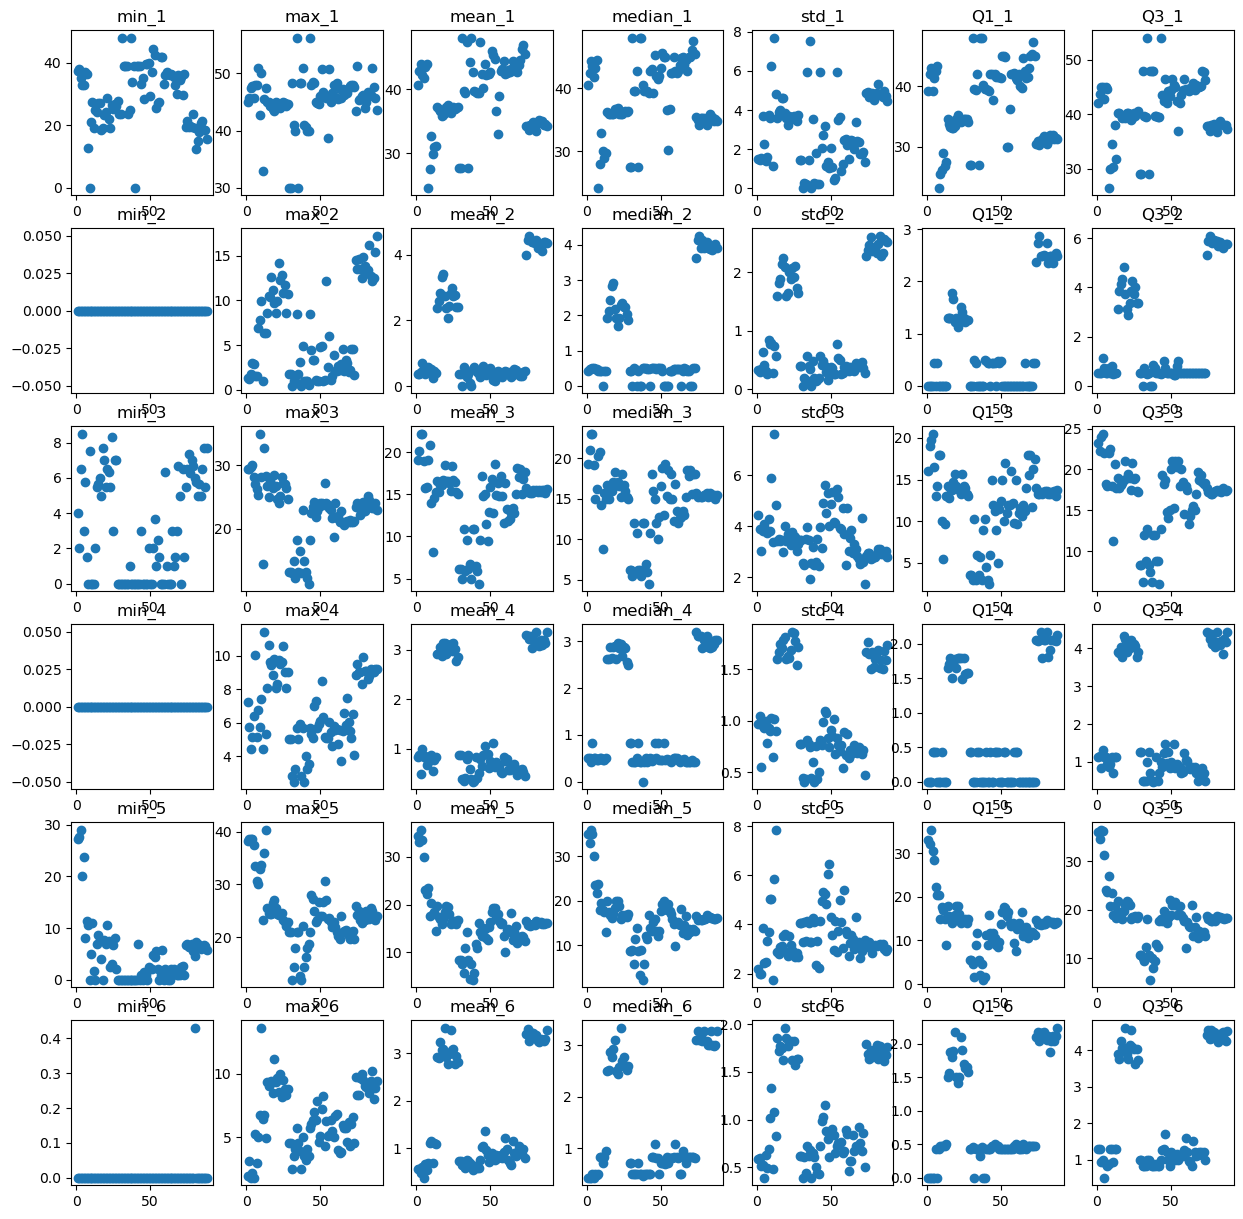

In [11]:
sns.set_context({'figure.figsize':[15, 15]})
for i in range(len(col_rename)):
    plt.subplot(6,7,i+1)
    plt.scatter(list(range(1,89)),list(features[col_rename[i]]))
    plt.title(col_rename[i])
plt.show()

    According to summary table above(focus on ranges and estimated standard deviations, I prefer to choose min value, max value and median value. Although the mins are always 0 for some time series, it still seems meaningful. Almost all features distribute well, and in terms of correlation between features, mean will be affected by max and min value, so I prefer median which will not be affcted. So I think min, max and median are fine.
    

### 2. ISLR 3.7.4
I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

### 2.a
Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. 

Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

    I think the cubic regression will have a lower training RSS. Because it could make a tighter and closer fit against data. 

### 2.b
Answer (a) using test rather than training RSS.

    When talking about test RSS I think the cubic regression will have a higher test RSS since the tighter fit in training may cause overfit and that will lead to more error.

### 2.c
Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. 

Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.


    I think cubic regression will have lower training RSS than the linear fit because of its higher flexibility which could fit the data closer no matter what the real relationship is.

### 2.d

    I think it depends on how far the real relationship from linear. If it is closer to linear than cubic, the test RSS of linear regression will be lower than that of cubic regression. If it is closer to cubic then the test RSS of cubic regression will be lower.
    
    So since there is no enough information, I can't tell which one will be lower. 

## hw4

### 4.a Binary Classification Using Logistic Regression

### 4.a.i
Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. 

Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook)

In [12]:
# choose min, max and median in 1(c)iv
# time series 1, 2, and 6 is avg_rss12, var_rss12 and var_rss23
# bending in training set are: 'bending1_3','bending1_4','bending1_5','bending1_6','bending1_7','bending2_3',
                             # 'bending2_4','bending2_5', bending2_6'
train_id_in_features = []
for i in trainsets:
    train_id_in_features.append(dfs_keys.index(i))

train_f = features.loc[train_id_in_features,]
train_f = train_f[["min_1","max_1","median_1","min_2","max_2","median_2","min_3","max_3","median_3",
                   "min_4","max_4","median_4","min_5","max_5","median_5","min_6","max_6","median_6",
                   "dataset","class"]]
#change class label to 0 and 1
train_f.loc[train_f["class"]=="bending","b_class"] = "1"
train_f.loc[train_f["class"]!="bending","b_class"] = "0"
train_f = train_f.reset_index().drop(["index"],axis=1)
train_f

,min_1,max_1,median_1,min_2,max_2,median_2,min_3,max_3,median_3,min_4,...,median_4,min_5,max_5,median_5,min_6,max_6,median_6,dataset,class,b_class
0,35.00,47.40,44.330,0.0,1.70,0.470,6.50,29.75,23.000,0.0,...,0.430,29.00,38.50,36.00,0.0,1.79,0.430,bending1_3,bending,1
1,33.00,47.75,43.500,0.0,3.00,0.500,8.50,30.00,23.000,0.0,...,0.830,20.00,38.67,35.00,0.0,2.18,0.500,bending1_4,bending,1
2,33.00,45.75,41.750,0.0,2.83,0.500,3.00,28.25,19.125,0.0,...,0.500,23.67,37.50,30.00,0.0,1.79,0.430,bending1_5,bending,1
3,37.00,48.00,43.250,0.0,1.58,0.470,5.75,27.00,15.000,0.0,...,0.500,8.00,33.50,23.50,0.0,5.26,0.500,bending1_6,bending,1
4,36.25,48.00,44.500,0.0,1.50,0.470,1.50,26.33,16.250,0.0,...,0.470,11.33,30.75,21.67,0.0,2.96,0.490,bending1_7,bending,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,35.290,0.0,12.68,3.900,5.00,23.75,15.330,0.0,...,3.000,6.00,25.50,16.25,0.0,9.39,3.270,walking_5,walking,0
65,21.50,51.00,35.500,0.0,12.21,3.845,6.50,23.33,15.500,0.0,...,2.870,6.33,25.00,16.25,0.0,10.21,3.015,walking_6,walking,0
66,18.33,47.67,34.750,0.0,12.48,3.900,7.67,23.33,15.500,0.0,...,2.930,6.67,24.00,16.00,0.0,8.01,2.980,walking_7,walking,0
67,18.33,45.75,35.125,0.0,15.37,4.025,5.50,24.00,15.000,0.0,...,3.015,6.50,23.25,16.00,0.0,8.86,3.015,walking_8,walking,0


In [13]:
# for time series 1, 2, and 6 of each instance
train_f_126 = train_f[["min_1","max_1","median_1","min_2","max_2","median_2","min_6","max_6","median_6","b_class"]]
train_f_126

,min_1,max_1,median_1,min_2,max_2,median_2,min_6,max_6,median_6,b_class
0,35.00,47.40,44.330,0.0,1.70,0.470,0.0,1.79,0.430,1
1,33.00,47.75,43.500,0.0,3.00,0.500,0.0,2.18,0.500,1
2,33.00,45.75,41.750,0.0,2.83,0.500,0.0,1.79,0.430,1
3,37.00,48.00,43.250,0.0,1.58,0.470,0.0,5.26,0.500,1
4,36.25,48.00,44.500,0.0,1.50,0.470,0.0,2.96,0.490,1
...,...,...,...,...,...,...,...,...,...,...
64,20.75,46.25,35.290,0.0,12.68,3.900,0.0,9.39,3.270,0
65,21.50,51.00,35.500,0.0,12.21,3.845,0.0,10.21,3.015,0
66,18.33,47.67,34.750,0.0,12.48,3.900,0.0,8.01,2.980,0
67,18.33,45.75,35.125,0.0,15.37,4.025,0.0,8.86,3.015,0


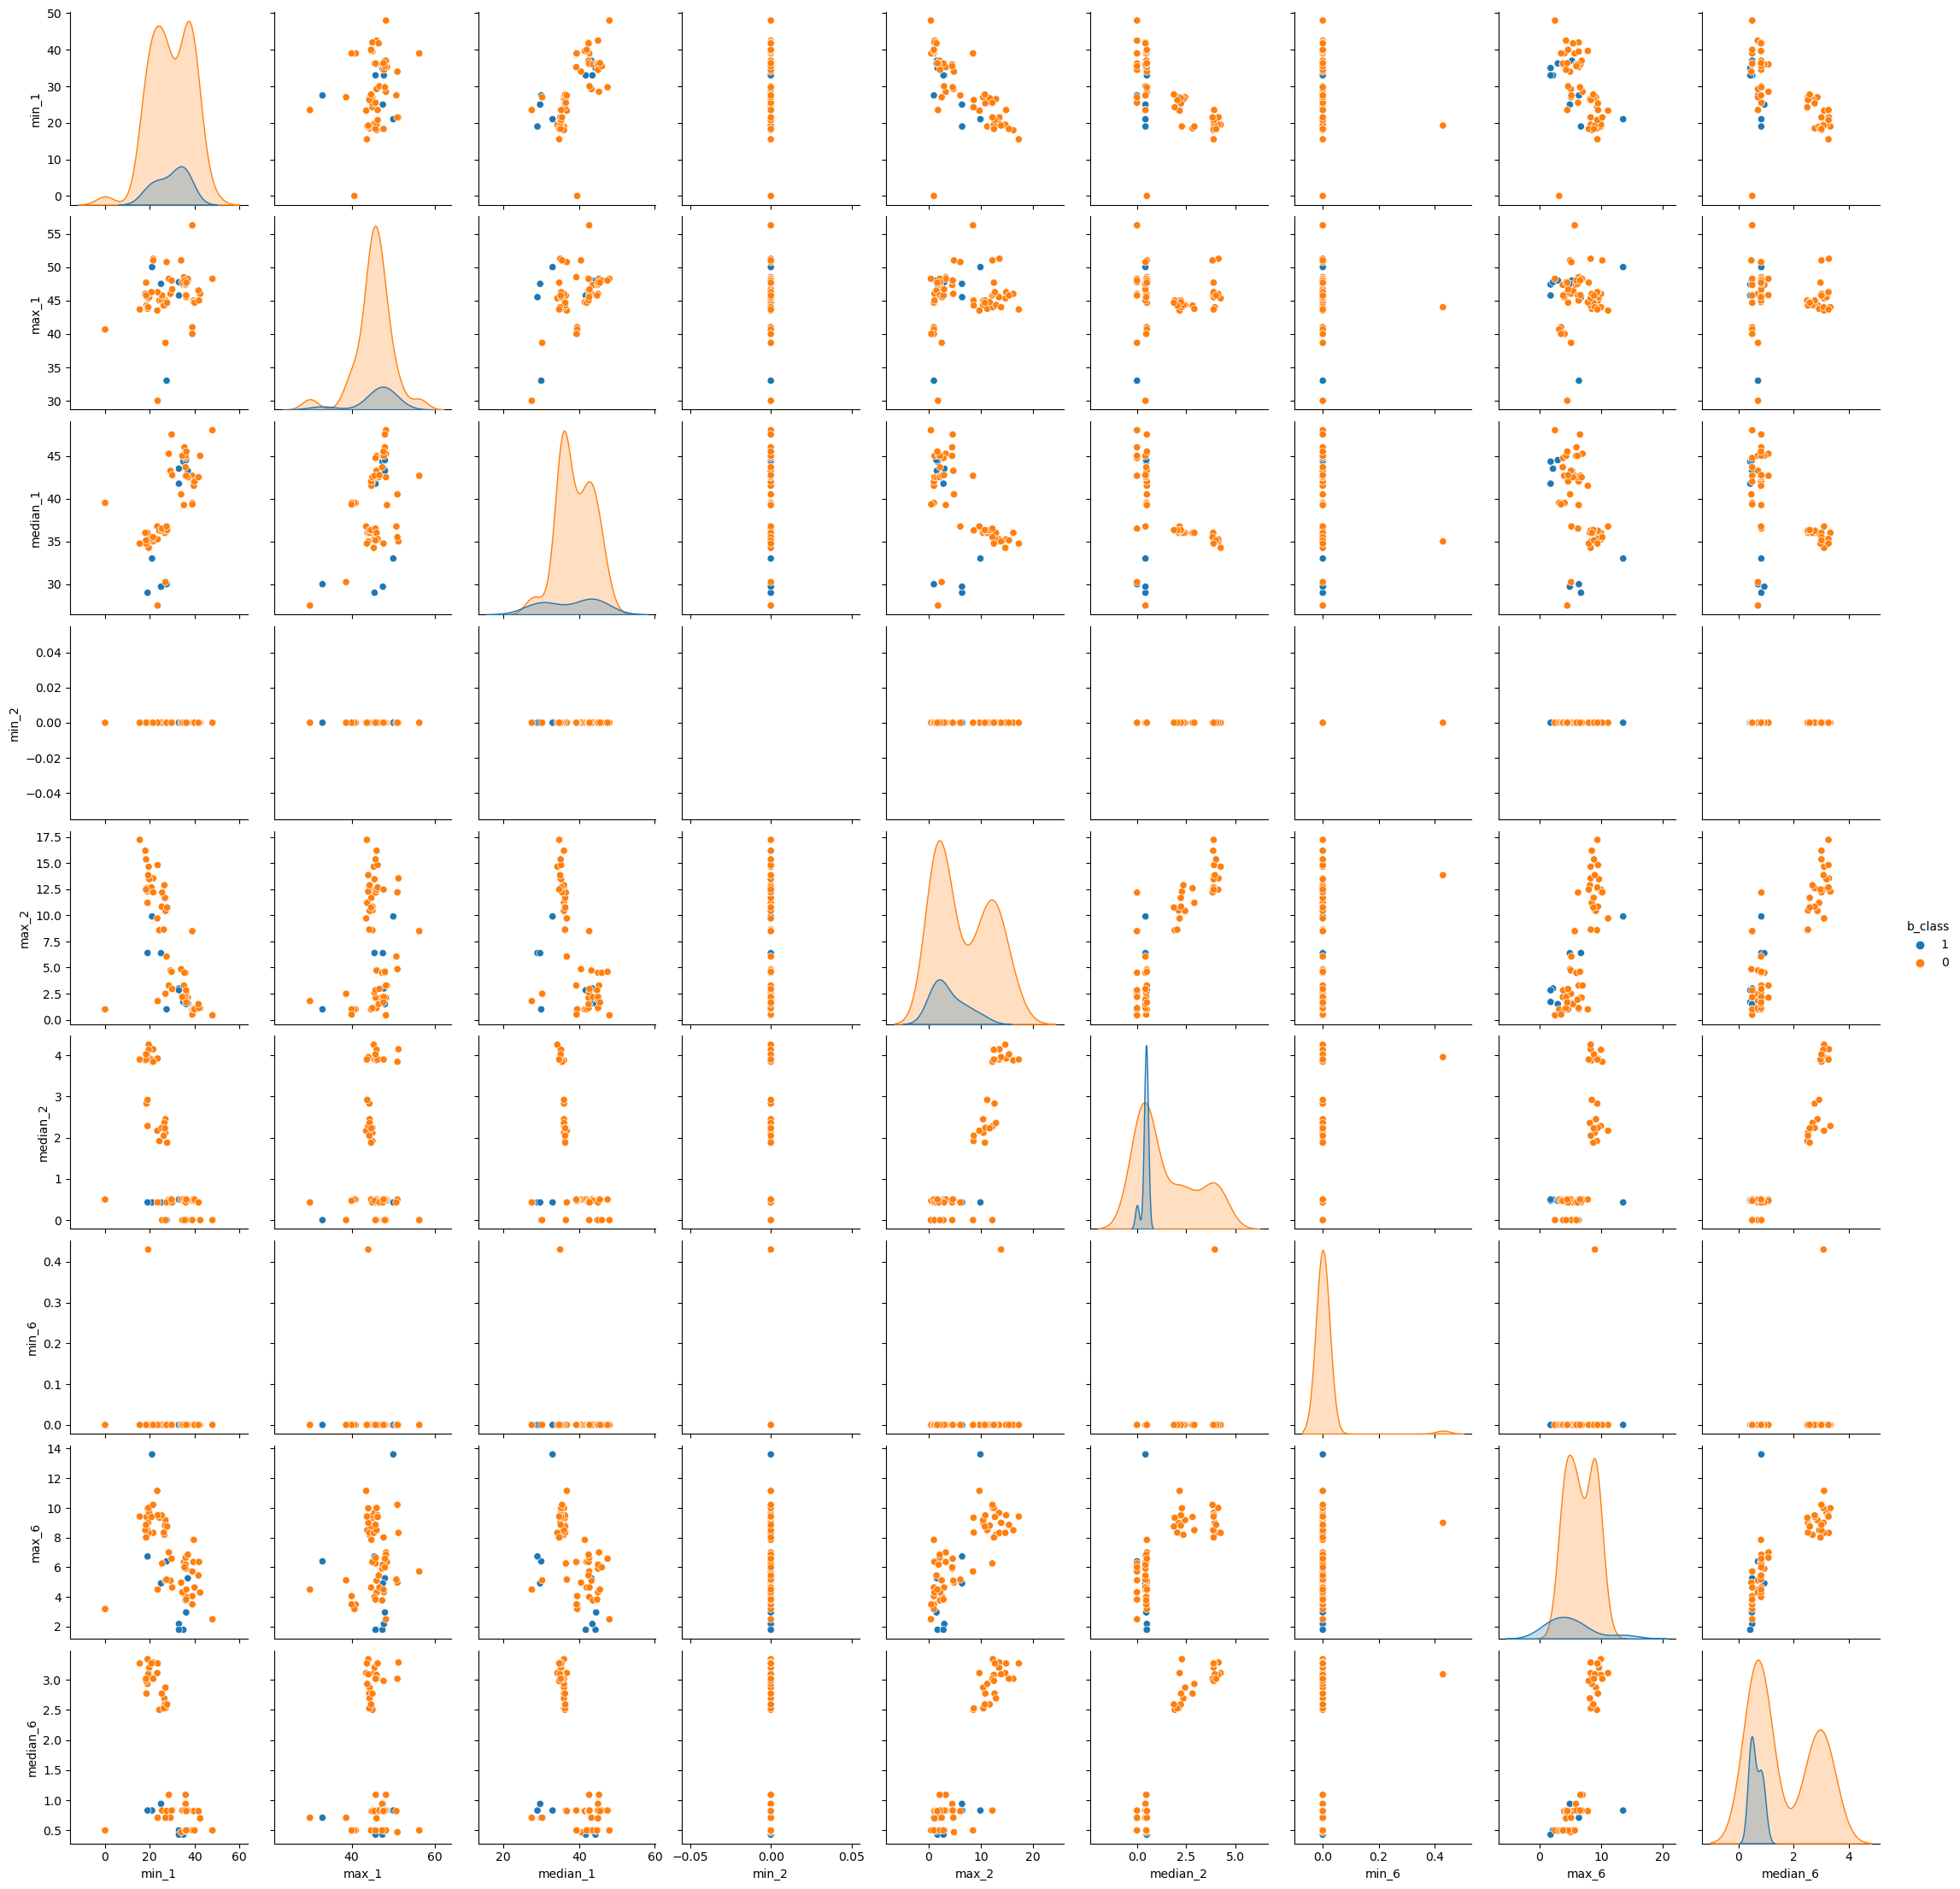

In [14]:
sns.set_context({'figure.figsize':[15, 15]})
sns.pairplot(train_f_126,hue="b_class")
plt.show()

### 4.a.ii. 
Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. 

In [15]:
def break_list_n(ls,n):
    parts = []
    if len(ls)%n == 0:
        length = len(ls)//n
    else:
        length = len(ls)//n+1
    for i in range(0,n):
#         yield ls[i*length:(i+1)*length]
        parts.append(ls[i*length:(i+1)*length])
    return parts

def break_time_series_l(df,l): #sitting_8 only has 479 valid rows
    total = list(range(480))
    parts = break_list_n(total,l)
    if df.iloc[0]["dataset"] == "sitting_8":
        parts[l-1].remove(479)

    dfs = []
    for i in range(l):
        if i != 0:
            dfs.append(df.loc[parts[i],].reset_index().drop(["time","index","dataset","class"],axis=1))
        else:
            dfs.append(df.loc[parts[i],].reset_index().drop(["time","index"],axis=1))

    ts_name = ["avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
    split_col_names = []
    
    for i in range(l):
        for name in ts_name:
            col_name = name+"_"+str(i+1)
            split_col_names.append(col_name)
    split_col_names = ["dataset","class"]+split_col_names

    res_df = pd.concat(dfs,axis=1)
    res_df.columns = split_col_names
    return res_df

In [16]:
for df in trainsets:
    tmp = break_time_series_l(locals()[df],2)
    if df == "bending1_3":
        df_train_2 = tmp
    else:
        df_train_2 = pd.concat([df_train_2,tmp])
# df_train_2 = df_train_2.reset_index().drop(["index","time_1","time_2"],axis=1)
df_train_2 = df_train_2.reset_index().drop(["index"],axis=1)
df_train_2

,dataset,class,avg_rss12_1,var_rss12_1,avg_rss13_1,var_rss13_1,avg_rss23_1,var_rss23_1,avg_rss12_2,var_rss12_2,avg_rss13_2,var_rss13_2,avg_rss23_2,var_rss23_2
0,bending1_3,bending,42.00,0.71,21.25,0.43,30.00,0.00,43.33,0.94,18.00,0.00,35.67,0.47
1,bending1_3,bending,41.50,0.50,20.25,1.48,31.25,1.09,44.20,0.75,19.75,0.83,35.40,1.20
2,bending1_3,bending,41.50,0.50,14.25,1.92,33.00,0.00,45.00,0.00,21.75,0.83,35.00,1.41
3,bending1_3,bending,40.75,0.83,15.75,0.43,33.00,0.00,45.00,0.00,23.33,0.47,36.00,0.00
4,bending1_3,bending,40.00,0.71,20.00,2.74,32.75,0.43,45.00,0.00,24.00,0.00,36.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16555,walking_9,walking,37.25,4.26,16.25,3.63,14.50,2.60,31.50,1.66,12.50,3.20,14.25,4.44
16556,walking_9,walking,24.25,3.27,12.25,1.79,13.50,5.59,27.33,1.25,11.33,0.94,20.00,4.00
16557,walking_9,walking,27.25,7.98,17.75,4.44,13.00,6.52,37.80,7.68,14.20,2.48,17.25,0.83
16558,walking_9,walking,41.00,4.06,16.00,3.24,15.50,5.41,33.75,1.30,15.75,5.21,16.50,2.69


Repeat the experiment in 4(a)i

i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 4(a)i?

In [17]:
# calculate min, max and median for each time series of the each training instances
def row_of_3_fearure_each(df):
    tmp = df[df["dataset"]==dataset]
    target_des = tmp.describe().loc[["min","max","50%"]]
    df_des = target_des.T.rename(columns={"50%":"median"})
    res = df_des.iloc[[0]].reset_index().loc[:,"min":]
    l = df_des.shape[0]
    for row in range(1,l):
        tmp = df_des.iloc[[row]].reset_index().loc[:,"min":]
        res = pd.concat([res,tmp],axis=1)

    f_name = ["min","max","median"]
    split_f_names = []
    for i in range(l):
        for name in f_name:
            col_name = name+"_"+str(i+1)
            split_f_names.append(col_name)
    res.columns = split_f_names
    res["dataset"] = dataset 
    res["class"] = re.findall(r"\D+",dataset.replace("_",""))[0]
    return res

In [18]:
for dataset in trainsets:
    df = df_train_2[df_train_2["dataset"]==dataset]
    tmp = row_of_3_fearure_each(df)
    if dataset == "bending1_3":
        train_f_2 = tmp
    else:
        train_f_2 = pd.concat([train_f_2,tmp])
train_f_2 = train_f_2.reset_index().drop(["index"],axis=1)
#change class label to 0 and 1
train_f_2.loc[train_f_2["class"]=="bending","b_class"] = "1"
train_f_2.loc[train_f_2["class"]!="bending","b_class"] = "0"

train_f_2

,min_1,max_1,median_1,min_2,max_2,median_2,min_3,max_3,median_3,min_4,...,median_10,min_11,max_11,median_11,min_12,max_12,median_12,dataset,class,b_class
0,36.50,46.50,44.500,0.0,1.50,0.470,14.25,29.25,24.000,0.00,...,0.43,29.00,38.25,36.000,0.00,1.50,0.000,bending1_3,bending,1
1,33.75,47.75,45.000,0.0,3.00,0.485,11.00,30.00,23.750,0.00,...,0.87,20.00,38.50,30.415,0.00,2.18,0.470,bending1_4,bending,1
2,33.00,45.75,42.330,0.0,2.83,0.500,3.00,28.25,19.500,0.00,...,0.47,26.00,36.00,29.750,0.00,1.50,0.430,bending1_5,bending,1
3,39.00,48.00,45.000,0.0,1.30,0.000,6.25,27.00,18.000,0.00,...,0.43,8.00,26.00,23.250,0.00,4.06,0.500,bending1_6,bending,1
4,36.67,45.00,43.710,0.0,1.30,0.470,4.00,26.33,16.875,0.00,...,0.47,13.75,26.00,21.750,0.00,2.96,0.500,bending1_7,bending,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,22.33,46.00,35.500,0.0,12.68,3.900,5.00,22.00,15.250,0.00,...,3.00,6.00,25.25,16.000,0.00,9.39,3.350,walking_5,walking,0
65,21.50,45.67,35.500,0.0,12.21,4.030,9.00,22.25,15.500,0.00,...,2.86,7.33,25.00,16.250,0.00,10.21,3.085,walking_6,walking,0
66,18.33,45.00,34.375,0.0,12.44,3.900,8.33,21.75,15.000,0.00,...,2.94,6.67,24.00,15.875,0.00,8.01,2.955,walking_7,walking,0
67,18.33,44.00,35.750,0.0,12.38,3.770,8.00,23.50,15.000,0.00,...,3.00,7.33,23.00,16.000,0.47,8.84,3.110,walking_8,walking,0


In [19]:
# need to plot for the time series 1,2,6,7,8,12 with the 3 features
plot_f = train_f_2[["min_1","max_1","median_1","min_2","max_2","median_2","min_6","max_6","median_6",
                                  "min_7","max_7","median_7","min_8","max_8","median_8","min_12","max_12","median_12",
                                  "b_class"]]
plot_f

,min_1,max_1,median_1,min_2,max_2,median_2,min_6,max_6,median_6,min_7,max_7,median_7,min_8,max_8,median_8,min_12,max_12,median_12,b_class
0,36.50,46.50,44.500,0.0,1.50,0.470,0.00,1.79,0.500,35.00,47.40,43.500,0.00,1.70,0.500,0.00,1.50,0.000,1
1,33.75,47.75,45.000,0.0,3.00,0.485,0.00,1.53,0.765,33.00,46.00,42.000,0.00,2.86,0.500,0.00,2.18,0.470,1
2,33.00,45.75,42.330,0.0,2.83,0.500,0.00,1.79,0.430,39.25,43.67,41.500,0.00,1.12,0.500,0.00,1.50,0.430,1
3,39.00,48.00,45.000,0.0,1.30,0.000,0.00,5.26,0.710,37.00,46.50,42.670,0.00,1.58,0.500,0.00,4.06,0.500,1
4,36.67,45.00,43.710,0.0,1.30,0.470,0.00,2.28,0.470,36.25,48.00,44.500,0.00,1.50,0.500,0.00,2.96,0.500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,22.33,46.00,35.500,0.0,12.68,3.900,0.00,8.83,3.035,20.75,46.25,35.000,0.43,12.09,3.960,0.00,9.39,3.350,0
65,21.50,45.67,35.500,0.0,12.21,4.030,0.00,9.19,3.000,21.75,51.00,35.585,0.00,11.41,3.670,0.00,10.21,3.085,0
66,18.33,45.00,34.375,0.0,12.44,3.900,0.43,7.89,3.015,20.33,47.67,35.000,0.00,12.48,3.935,0.00,8.01,2.955,0
67,18.33,44.00,35.750,0.0,12.38,3.770,0.00,8.86,2.870,22.67,45.75,35.000,0.00,15.37,4.075,0.47,8.84,3.110,0


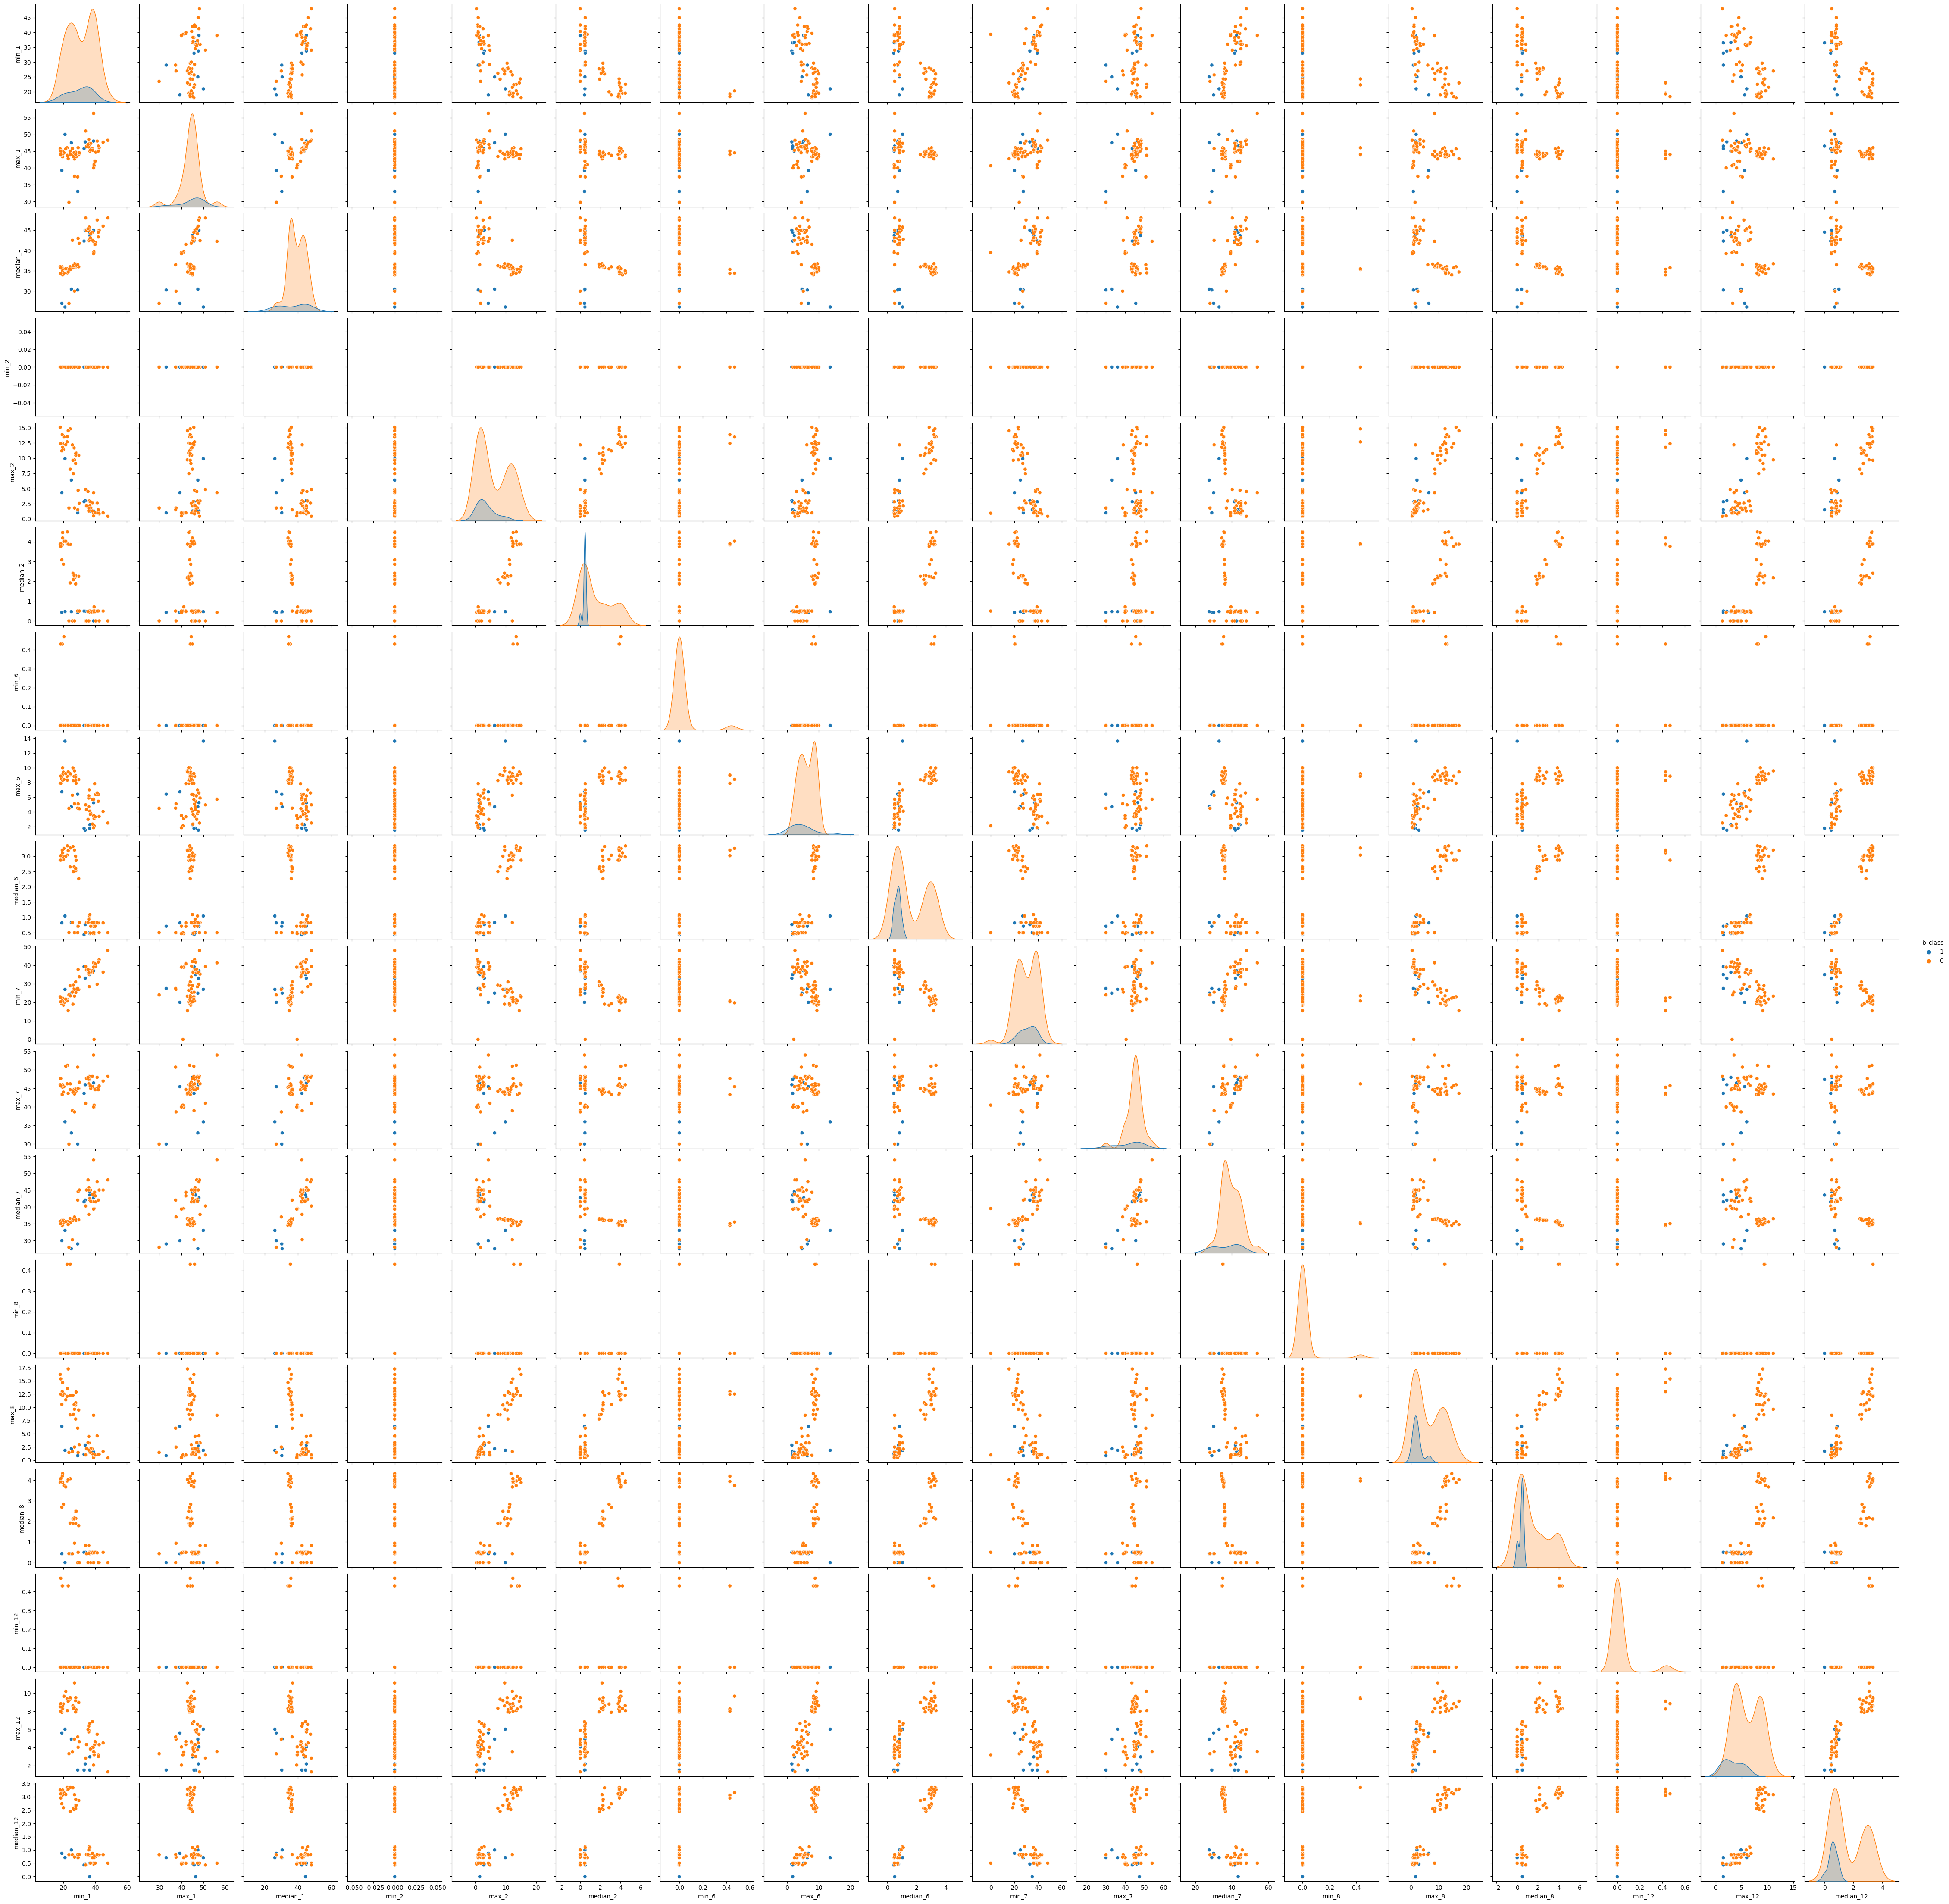

<Figure size 3000x3000 with 0 Axes>

In [20]:
# sns.set_context({'figure.figsize':[30, 30]})
sns.pairplot(plot_f,hue="b_class")
plt.figure(figsize=(30,30))
plt.show()

**difference with those of 4(a)i?**

Although the time series are broken into two approximately equal lenth parts, their corresponding relationships don;t seem to change a lot. For example, the scatter plots of min_1 vs max_1 and min_1 vs max_7 are pretty silimay, both are presenting like a vertical line with many outer points. So this means, our operation of spliting time serise doesn't affect the relationships and effects of each features of each instance.

### 4.a.iii. 

**Break each time series** in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and **use logistic regression** to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. 

In [21]:
# generate 20 dataframe df_train,df_train_2,...,df_train_l,...,df_train_20
# we already have l=1(df_train) and l=2(df_train_2), so l starts at l=3 and name dfs as df_train_l
# use function break_time_series_l(df,l) defined before
for l in range(3,21):
    for df in trainsets:
        tmp = break_time_series_l(locals()[df],l)
        if df == "bending1_3":
            locals()["df_train_"+str(l)] = tmp
        else:
            locals()["df_train_"+str(l)] = pd.concat([locals()["df_train_"+str(l)],tmp])
    # df_train_2 = df_train_2.reset_index().drop(["index","time_1","time_2"],axis=1)
    locals()["df_train_"+str(l)] = locals()["df_train_"+str(l)].reset_index().drop(["index"],axis=1)

In [22]:
# now we get df_train_1,df_train_2,...,df_train_20
df_train_1 = df_train
df_train_5

,dataset,class,avg_rss12_1,var_rss12_1,avg_rss13_1,var_rss13_1,avg_rss23_1,var_rss23_1,avg_rss12_2,var_rss12_2,...,avg_rss13_4,var_rss13_4,avg_rss23_4,var_rss23_4,avg_rss12_5,var_rss12_5,avg_rss13_5,var_rss13_5,avg_rss23_5,var_rss23_5
0,bending1_3,bending,42.00,0.71,21.25,0.43,30.00,0.00,42.00,0.00,...,26.25,0.43,30.00,0.00,44.25,0.83,19.00,0.00,36.50,0.50
1,bending1_3,bending,41.50,0.50,20.25,1.48,31.25,1.09,42.00,0.00,...,26.50,0.50,31.00,0.71,43.67,0.47,20.33,0.47,36.33,0.47
2,bending1_3,bending,41.50,0.50,14.25,1.92,33.00,0.00,42.00,0.00,...,25.75,0.43,32.00,0.00,43.50,0.50,19.00,0.00,36.67,0.47
3,bending1_3,bending,40.75,0.83,15.75,0.43,33.00,0.00,42.00,0.00,...,26.25,0.43,32.00,0.00,43.17,0.69,18.20,0.40,36.20,0.40
4,bending1_3,bending,40.00,0.71,20.00,2.74,32.75,0.43,42.00,0.00,...,25.00,0.71,32.00,0.00,43.25,0.43,18.00,0.00,36.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619,walking_9,walking,30.00,4.55,16.25,4.76,21.00,2.12,37.50,5.41,...,17.75,3.19,16.00,4.06,31.50,1.66,12.50,3.20,14.25,4.44
6620,walking_9,walking,36.00,0.00,10.50,5.32,14.33,4.03,38.25,3.90,...,15.00,1.41,17.75,1.48,27.33,1.25,11.33,0.94,20.00,4.00
6621,walking_9,walking,39.00,6.60,8.25,3.77,5.75,3.27,35.50,3.35,...,14.00,3.39,12.25,3.96,37.80,7.68,14.20,2.48,17.25,0.83
6622,walking_9,walking,31.00,2.92,9.33,4.19,14.75,4.60,36.75,11.45,...,18.67,2.36,16.33,2.36,33.75,1.30,15.75,5.21,16.50,2.69


In [23]:
# using min, max, median and other features to do binary classification
# we have df_train,df_train_2,...,df_train_20 and now to get their features
# we already have l=1(train_f) and l=2(train_f_2), so l starts at l=3 and name dfs as train_f_l
# use function row_of_3_fearure_each(df) defined, then generate 20 dfs with 69 rows and 18*l+3 colums
for i in range(3,21):
    tmp_df_train = locals()["df_train_"+str(i)]
    for dataset in trainsets:
        df = tmp_df_train[tmp_df_train["dataset"]==dataset]
        tmp = row_of_3_fearure_each(df)
        if dataset == "bending1_3":
            locals()["train_f_"+str(i)] = tmp
        else:
            locals()["train_f_"+str(i)] = pd.concat([locals()["train_f_"+str(i)],tmp])
            
    locals()["train_f_"+str(i)] = locals()["train_f_"+str(i)].reset_index().drop(["index"],axis=1)
    locals()["train_f_"+str(i)].loc[locals()["train_f_"+str(i)]["class"]=="bending","b_class"] = "1"
    locals()["train_f_"+str(i)].loc[locals()["train_f_"+str(i)]["class"]!="bending","b_class"] = "0"

In [24]:
# now we get train_f_1,train_f_2,...,train_f_20
train_f_1 = train_f
train_f_5

,min_1,max_1,median_1,min_2,max_2,median_2,min_3,max_3,median_3,min_4,...,median_28,min_29,max_29,median_29,min_30,max_30,median_30,dataset,class,b_class
0,40.00,45.00,44.500,0.00,1.00,0.470,14.25,25.00,23.875,0.00,...,0.430,35.25,36.67,36.000,0.00,1.30,0.000,bending1_3,bending,1
1,35.75,47.75,45.000,0.00,3.00,0.470,11.00,30.00,23.750,0.00,...,0.710,20.00,35.50,27.415,0.00,2.18,0.470,bending1_4,bending,1
2,34.50,45.00,41.875,0.00,1.58,0.500,3.00,28.00,21.500,0.00,...,0.470,26.00,30.50,27.585,0.00,1.00,0.430,bending1_5,bending,1
3,41.00,46.75,45.000,0.00,1.30,0.000,7.75,24.00,18.330,0.00,...,0.430,8.00,25.00,23.500,0.00,4.06,0.470,bending1_6,bending,1
4,40.75,45.00,42.500,0.00,1.12,0.470,4.00,26.33,15.125,0.00,...,0.710,13.75,26.00,22.330,0.00,2.62,0.710,bending1_7,bending,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,25.50,46.00,35.710,0.00,9.07,3.900,5.00,20.67,15.000,0.47,...,3.200,7.67,23.75,15.750,0.43,7.85,3.350,walking_5,walking,0
65,21.50,44.50,34.775,0.00,10.71,3.680,9.00,22.25,15.500,0.47,...,2.830,8.00,23.00,15.750,0.43,10.21,2.945,walking_6,walking,0
66,18.33,43.33,34.375,0.00,10.82,4.060,8.33,21.67,15.250,0.00,...,2.800,6.67,24.00,15.250,0.00,7.46,2.935,walking_7,walking,0
67,19.33,44.00,36.250,0.47,12.38,3.900,8.67,22.50,15.000,0.00,...,2.895,7.33,22.00,15.875,0.50,8.22,3.155,walking_8,walking,0


**Calculate the p-values** for your logistic regression parameters in each model corresponding to each value of **l** and **refit a logistic regression model using your pruned set of features**. 

Alternatively, you can use **backward selection** using **sklearn.feature_selection** or **glm in R**. Use **5-fold cross-validation** to **determine the best value of the pair (l, p)**, where p is the number of features used in recursive feature elimination. 

（R calculates the p-values for logistic regression automatically. One way of calculating them in Python is to call R within Python. There are other ways to obtain the p-values as well.）

**Explain what the right way and the wrong way are to perform cross-validation** in this problem(This is an interesting problem in which the number of features changes depending on the value of the parameter l that is selected via cross validation. Another example of such a problem is Principal Component Regression, where the number of principal components is selected via cross validation.
 ). 
 
Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use **stratified cross validation**. Research what it means and use it if needed.

<!-- In the following, you can see an example of applying Python’s Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression.
```python
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load the iris datasets dataset = datasets . load iris ()
# create a base classifier used to evaluate a subset of attributes model = LogisticRegression ()
# create the RFE model and select 3 attributes rfe =RFE(model, 3)
rfe = rfe.fit(dataset.data, dataset.target)
# summarize the selection of the attributes print ( rfe . support )
print(rfe.ranking )
``` -->

### Answer:

**the right way** is to do recursive feature elimination using 5-fold cross-validation for each instance, and then select the most suitable predictors for the training set

**the wrong way** is to choose p predictors(for example, p features that have highest correlation with the "b_class" label) before doing cross-validation and then use these p predictors to get the outcome

In [25]:
# Use 5-fold cross-validation
logR = LogisticRegression()
rfecv = RFECV(estimator=logR,step=1)
l_p = {}
for l in range(1,21):
    df = "train_f_"+str(l)
    X_train = locals()[df].loc[:,:locals()[df].columns[-4]]
    y_train = locals()[df]["b_class"]
    rfecv.fit(X_train,y_train)
    p = rfecv.n_features_ # optimal p for given l
    cv_score = rfecv.cv_results_["mean_test_score"][p-1]
    l_p[(l,p)] = cv_score
    print((l,p),cv_score)

(1, 5) 0.9857142857142858
(2, 6) 0.9714285714285715
(3, 1) 0.9857142857142858
(4, 5) 0.9714285714285715
(5, 44) 0.9560439560439562
(6, 10) 0.9714285714285715
(7, 7) 0.9714285714285715
(8, 6) 0.9714285714285715
(9, 119) 0.9560439560439562
(10, 98) 0.9560439560439562
(11, 67) 0.9560439560439562
(12, 4) 0.9571428571428573
(13, 20) 0.9714285714285715
(14, 3) 0.9714285714285715
(15, 17) 0.9417582417582417
(16, 28) 0.956043956043956
(17, 112) 0.9560439560439562
(18, 1) 0.9714285714285715
(19, 1) 0.9714285714285715
(20, 14) 0.9714285714285715


In [26]:
# find optimal (l,p) pair
optimal_lp = max(l_p, key=l_p.get)
print("optimal (l,p) is:",optimal_lp,"and its cv score is:",l_p[optimal_lp])

refit_df = locals()["train_f_"+str(optimal_lp[0])]
X_train = refit_df.loc[:,:refit_df.columns[-4]]
y_train = refit_df["b_class"]
rfecv = RFECV(estimator=logR,step=1)
rfecv.fit(X_train,y_train)
f_list = [i for i,id in enumerate(list(rfecv.ranking_)) if id == 1]
chosen_f = list(refit_df.columns[:-3][f_list])
print("selected features are:",chosen_f)

optimal (l,p) is: (1, 5) and its cv score is: 0.9857142857142858
selected features are: ['median_1', 'median_3', 'min_5', 'max_5', 'median_5']


In [27]:
# refit model using optimal (l,p) pair:(2, 27)
X_train = refit_df[chosen_f]
y_train = refit_df["b_class"]
logR.fit(X_train,y_train)

LogisticRegression()

### 4.a.iv
Report the **confusion matrix** and show the **ROC and AUC** for your classifier on train data. 


In [28]:
y_train_pred = logR.predict(X_train)

In [29]:
# confusion matrix 
conf_matrix_train=confusion_matrix(y_train,y_train_pred)
print(conf_matrix_train)

[[60  0]
 [ 0  9]]


AUC is:  1.0


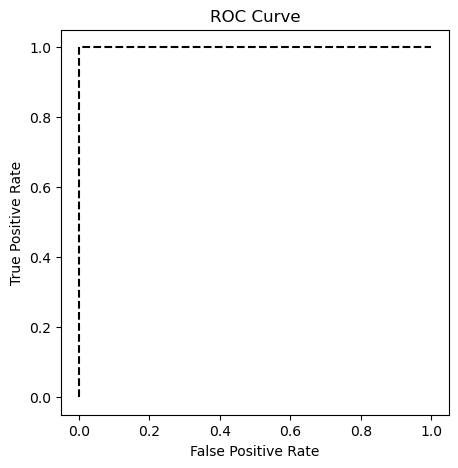

In [30]:
# show ROC and AUC
fpr,tpr,thersholds = roc_curve(y_train,y_train_pred.astype(int),pos_label="1")
roc_auc = auc(fpr,tpr)
print("AUC is: ",roc_auc)

sns.set_context({'figure.figsize':[5, 5]})
plt.plot(fpr, tpr, 'k--', label='ROC'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve')
plt.show()

Report the **parameters of your logistic regression βi’s** as well as the **p-values** associated with them.

In [31]:
# parameters of your logistic regression βi’s and p-values associated with them
# X_train_const = sm.add_constant(X_train)
# y_train_int = y_train.astype(int)
# res = sm.Logit(y_train_int,X_train_const).fit(method="lbfgs")
# print(res.summary())

model = sm.GLM(y_train.astype(int),sm.add_constant(X_train))
res = model.fit(method="lbfgs")
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                b_class   No. Observations:                   69
Model:                            GLM   Df Residuals:                       63
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                        0.038352
Method:                         lbfgs   Log-Likelihood:                 17.735
Date:                Sun, 16 Oct 2022   Deviance:                       2.4161
Time:                        23:48:04   Pearson chi2:                     2.42
No. Iterations:                     0   Pseudo R-squ. (CS):             0.8711
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0228      0.251     -4.083      0.0

### 4.a.v
**Test the classifier on the test set**. 

**Remember** to break the time series in your test set into the same number of time series into which you broke your training set. **Remember** that the classifier has to be tested using the features extracted from the test set. 

In [32]:
# break time series as what we do for training set and get features of each time series
# meaning generate test_f_1 like train_f_1 
# use function row_of_3_fearure_each(df)
df_test_1 = df_test.drop(["time"],axis=1)
for dataset in testsets:
    df = df_test_1[df_test_1["dataset"]==dataset]
    tmp = row_of_3_fearure_each(df)
    if dataset == "bending1_1":
        test_f_1 = tmp
    else:
        test_f_1 = pd.concat([test_f_1,tmp])
test_f_1 = test_f_1.reset_index().drop(["index"],axis=1)
#change class label to 0 and 1
test_f_1.loc[test_f_1["class"]=="bending","b_class"] = "1"
test_f_1.loc[test_f_1["class"]!="bending","b_class"] = "0"

test_f_1

,min_1,max_1,median_1,min_2,max_2,median_2,min_3,max_3,median_3,min_4,...,median_4,min_5,max_5,median_5,min_6,max_6,median_6,dataset,class,b_class
0,37.25,45.00,40.500,0.0,1.30,0.430,4.00,29.50,19.250,0.0,...,0.500,27.25,38.25,35.000,0.0,1.92,0.430,bending1_1,bending,1
1,38.00,45.67,42.500,0.0,1.22,0.470,2.00,29.50,21.000,0.0,...,0.500,27.67,38.50,33.000,0.0,3.11,0.430,bending1_2,bending,1
2,12.75,51.00,24.250,0.0,6.87,0.430,0.00,25.33,20.250,0.0,...,0.470,10.67,30.00,23.750,0.0,4.97,0.500,bending2_1,bending,1
3,0.00,42.75,28.000,0.0,7.76,0.430,7.50,35.00,20.750,0.0,...,0.500,0.00,33.00,18.000,0.0,6.76,0.830,bending2_2,bending,1
4,24.25,45.00,36.250,0.0,8.58,1.920,5.50,26.75,16.670,0.0,...,2.620,7.00,25.50,20.000,0.0,9.34,2.500,cycling_1,cycling,0
5,28.75,44.75,36.875,0.0,9.91,1.700,6.50,24.67,17.000,0.0,...,2.950,10.50,24.33,20.000,0.0,9.62,2.450,cycling_2,cycling,0
6,22.00,44.67,36.000,0.0,14.17,1.920,6.33,24.00,16.500,0.0,...,2.860,7.50,24.25,18.875,0.0,8.55,2.570,cycling_3,cycling,0
7,23.50,30.00,27.500,0.0,1.79,0.430,0.00,13.25,6.250,0.0,...,0.820,0.00,21.00,8.750,0.0,4.50,0.710,lying_1,lying,0
8,24.75,48.33,48.000,0.0,3.11,0.000,1.00,16.50,6.250,0.0,...,0.430,0.00,12.75,3.330,0.0,3.91,0.500,lying_2,lying,0
9,48.00,48.25,48.000,0.0,0.43,0.000,0.00,13.00,5.500,0.0,...,0.430,0.00,12.00,9.000,0.0,2.50,0.500,lying_3,lying,0


In [33]:
X_test = test_f_1[chosen_f]
y_test = test_f_1["b_class"]
y_test_pred = logR.predict(X_test)

**Compare the accuracy on the test set with the cross-validation accuracy** you obtained previously.

In [34]:
# accuracy on train set
accuracy_score(y_train, y_train_pred)

1.0

In [35]:
# accuracy on test set
accuracy_score(y_test, y_test_pred)

0.9473684210526315

    the accuracy on train set is 1 and on test set is 0.95, meaning our model may be overfitting

### 4.a.vi
Do your classes seem to be well-separated to **cause instability** in calculating logistic regression parameters?

    Yes, it says "Perfect separation detected, results not available" when I use statsmodels to do logistic regression

### 4.a.vii
From the confusion matrices you obtained, do you see imbalanced classes? 

If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

In [36]:
conf_matrix_test=confusion_matrix(y_test,y_test_pred)
print(conf_matrix_train,conf_matrix_train[1][1]/sum(sum(conf_matrix_train)))
print(conf_matrix_test,conf_matrix_test[1][1]/sum(sum(conf_matrix_test)))

[[60  0]
 [ 0  9]] 0.13043478260869565
[[15  0]
 [ 1  3]] 0.15789473684210525


    yes, I think there is imbalance since the proportion of positive label in training set is less than 20%

In [37]:
# resample data
smo = SMOTE()
X_train_resample,y_train_resample = smo.fit_resample(X_train,y_train)

# refit model use resampled data
logR.fit(X_train_resample,y_train_resample)

LogisticRegression()

In [38]:
# confusion matrix, ROC, and AUC on train set
y_train_re_pred = logR.predict(X_train_resample)
conf_matrix_train_re = confusion_matrix(y_train_resample,y_train_re_pred)
print(conf_matrix_train_re)

[[60  0]
 [ 0 60]]


AUC is:  1.0


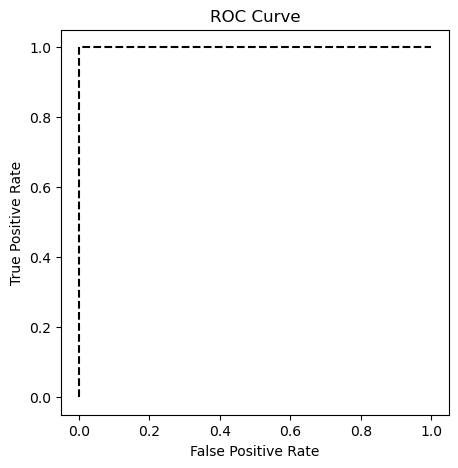

In [39]:
# show ROC and AUC
fpr,tpr,thersholds = roc_curve(y_train_resample,y_train_re_pred.astype(int),pos_label="1")
roc_auc = auc(fpr,tpr)
print("AUC is: ",roc_auc)

sns.set_context({'figure.figsize':[5, 5]})
plt.plot(fpr, tpr, 'k--', label='ROC'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve')
plt.show()

In [40]:
# confusion matrix, ROC, and AUC on test set
y_test_re_pred = logR.predict(X_test)
conf_matrix_test_re = confusion_matrix(y_test,y_test_re_pred)
print(conf_matrix_test_re)

[[15  0]
 [ 1  3]]


AUC is:  0.875


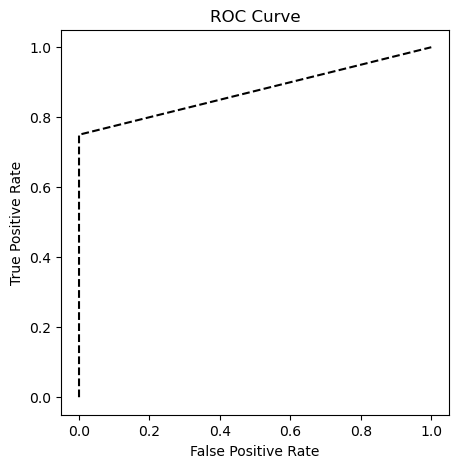

In [41]:
# show ROC and AUC
fpr,tpr,thersholds = roc_curve(y_test,y_test_re_pred.astype(int),pos_label="1")
roc_auc = auc(fpr,tpr)
print("AUC is: ",roc_auc)

sns.set_context({'figure.figsize':[5, 5]})
plt.plot(fpr, tpr, 'k--', label='ROC'.format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  
plt.title('ROC Curve')
plt.show()

### 4.b Binary Classification Using L1-penalized logistic regression

### 4.b.i 
**Repeat 4(a)iii** using L1-penalized logistic regression(you may want to use **normalized/standardized features**), i.e. instead of using p-values for variable selection, use L1 regularization. 

Note that in this problem, you have to **cross-validate for both l**, the number of time series into which you break each of your instances, **and λ**, the weight of L1 penalty in your logistic regression objective function (or **C**, the budget). Packages usually perform cross-validation for λ automatically.(Using the **package Liblinear** is strongly recommended.)

In [42]:
# use L1-penalized logistic regression to solve the binary classification
# 5-fold cross-validation to determine the best value of the pair (l, p)
logRcv = LogisticRegressionCV(penalty="l1",solver="liblinear")#,cv=
rfecv = RFECV(estimator=logRcv,step=1)
l_p_cv = {}
for l in range(1,21):
    df = "train_f_"+str(l)
    X_train = locals()[df].loc[:,:locals()[df].columns[-4]]
    y_train = locals()[df]["b_class"]
    rfecv.fit(X_train,y_train)
    p = rfecv.n_features_ # optimal p for given l
    cv_score = rfecv.cv_results_["mean_test_score"][p-1]
    l_p_cv[(l,p)] = cv_score
    print((l,p),cv_score)

(1, 15) 0.9714285714285715
(2, 7) 0.9714285714285715
(3, 10) 1.0
(4, 7) 0.9857142857142858
(5, 48) 0.9417582417582417
(6, 64) 0.9571428571428571
(7, 14) 0.9714285714285715
(8, 124) 0.9714285714285715
(9, 1) 0.9571428571428573
(10, 1) 0.9714285714285715
(11, 5) 0.9714285714285715
(12, 140) 0.9714285714285715
(13, 9) 0.9857142857142858
(14, 3) 0.9857142857142858
(15, 29) 0.9560439560439562
(16, 102) 0.9560439560439562
(17, 8) 0.9703296703296704
(18, 23) 0.9846153846153847
(19, 4) 0.9571428571428573
(20, 337) 0.9846153846153847


In [43]:
# find optimal (l,p) pair
optimal_lp = max(l_p_cv, key=l_p_cv.get)
print("optimal (l,p) is:",optimal_lp,"and its cv score is:",l_p_cv[optimal_lp])

refit_df = locals()["train_f_"+str(optimal_lp[0])]
X_train = refit_df.loc[:,:refit_df.columns[-4]]
y_train = refit_df["b_class"]
rfecv = RFECV(estimator=logRcv,step=1)
rfecv.fit(X_train,y_train)
f_list = [i for i,id in enumerate(list(rfecv.ranking_)) if id == 1]
chosen_f = list(refit_df.columns[:-3][f_list])
print("selected features are:",chosen_f)

optimal (l,p) is: (3, 10) and its cv score is: 1.0
selected features are: ['max_2', 'max_5', 'max_7', 'min_17']


In [44]:
# refit model using optimal (l,p) pair:(4, 2) 
X_train = refit_df[chosen_f]
y_train = refit_df["b_class"]
logRcv.fit(X_train,y_train)
logRcv.C_

array([0.35938137])

In [45]:
# refit model
model = sm.GLM(y_train.astype(int),sm.add_constant(X_train))
res = model.fit(method="lbfgs")
print(res.summary())

# X_train_const = sm.add_constant(X_train)
# y_train_int = y_train.astype(int)
# res = sm.Logit(y_train_int,X_train_const).fit(method="lbfgs")
# print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                b_class   No. Observations:                   69
Model:                            GLM   Df Residuals:                       64
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                        0.031175
Method:                         lbfgs   Log-Likelihood:                 24.339
Date:                Sun, 16 Oct 2022   Deviance:                       1.9952
Time:                        23:59:10   Pearson chi2:                     2.00
No. Iterations:                     0   Pseudo R-squ. (CS):             0.9337
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.221      0.069      0.9

### 4.b.ii
Compare the **L1-penalized** with **variable selection** using **p-values**. 

Which one performs better? Which one is easier to implement?

    Didn't use p-values to do variable selection.
    
    But comparing pure logistic regression and L1-penalized logistic regression, we can see 

### 4.c Multi-class Classification (The Realistic Case)

### 4.c.i 
**Find the best l** in the same way as you found it in 4(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set.(New versions of scikit learn allow using L1-penalty for multinomial regression.)

In [46]:
# use L1-penalized logistic regression to solve the Multi-class classification
# 5-fold cross-validation to determine the best value of the pair (l, p)
logRcv = LogisticRegressionCV(penalty="l1",solver="saga",multi_class="multinomial")
rfecv = RFECV(estimator=logRcv,step=1)
l_p_cv_mult = {}

# since the running time is too long and ls larger then 6 are always not optimal, so only calculate l<=5
for l in range(1,6):
    df = "train_f_"+str(l)
    X_train = locals()[df].loc[:,:locals()[df].columns[-4]]
    y_train = locals()[df]["class"]
    rfecv.fit(X_train,y_train)
    p = rfecv.n_features_ # optimal p for given l
    cv_score = rfecv.cv_results_["mean_test_score"][p-1]
    l_p_cv_mult[(l,p)] = cv_score
    print((l,p),cv_score)

(1, 9) 0.8692307692307691
(2, 23) 0.8120879120879121
(3, 25) 0.8131868131868132
(4, 38) 0.8406593406593407
(5, 44) 0.8131868131868132


In [47]:
# find optimal (l,p) pair
optimal_lp = max(l_p_cv_mult, key=l_p_cv_mult.get)
print("optimal (l,p) is:",optimal_lp,"and its cv score is:",l_p_cv_mult[optimal_lp])

refit_df = locals()["train_f_"+str(optimal_lp[0])]
X_train = refit_df.loc[:,:refit_df.columns[-4]]
y_train = refit_df["class"]
rfecv = RFECV(estimator=logRcv,step=1)
rfecv.fit(X_train,y_train)
f_list = [i for i,id in enumerate(list(rfecv.ranking_)) if id == 1]
chosen_f = list(refit_df.columns[:-3][f_list])
print("selected features are:",chosen_f)

optimal (l,p) is: (1, 9) and its cv score is: 0.8692307692307691
selected features are: ['max_1', 'median_1', 'max_2', 'min_3', 'max_3', 'median_3', 'min_5', 'max_5', 'median_5']


**Report your test error**. 

In [48]:
# refit model 
X_train = refit_df[chosen_f]
y_train = refit_df["class"]
logRcv.fit(X_train,y_train)

X_test = test_f_1[chosen_f]
y_test = test_f_1["class"]
y_train_pred = logRcv.predict(X_train)
y_test_pred = logRcv.predict(X_test)

In [49]:
# calculate test error
1-accuracy_score(y_test,y_test_pred)

0.1578947368421053

Research how **confusion matrices** and **ROC curves** are defined for multiclass classification and show them for this problem if possible.(For example, the pROC package in R does the job)

In [50]:
# confusion matrices for train set 
confusion_matrix(y_train,y_train_pred)

array([[ 9,  0,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0],
       [ 0,  1,  0, 11,  0,  0],
       [ 0,  0,  0,  1, 11,  0],
       [ 0,  0,  0,  0,  0, 12]])

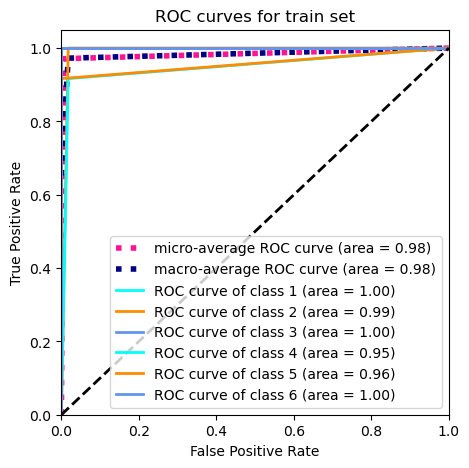

In [51]:
# ROC curves for train set 
y_train = pd.DataFrame(y_train)["class"].map({"bending":"1","cycling":"2","lying":"3","sitting":"4",
                                               "standing":"5","walking":"6"})
y_train_pred = pd.DataFrame(y_train_pred)[0].map({"bending":"1","cycling":"2","lying":"3","sitting":"4",
                                                  "standing":"5","walking":"6"})

y_train = label_binarize(y_train, classes=["1","2","3","4","5","6"])
y_train_pred = label_binarize(y_train_pred, classes=["1","2","3","4","5","6"])

fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_train.shape[1]):
    fpr[i],tpr[i],_ = roc_curve(y_train[:,i], y_train_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"],tpr["micro"], _ = roc_curve(y_train.ravel(), y_train_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_train.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_train.shape[1]):
    mean_tpr += interp(all_fpr,fpr[i],tpr[i])

# Finally average it and compute AUC
mean_tpr /= y_train.shape[1]
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label="micro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc["micro"]),
         color="deeppink", linestyle=":", linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label="macro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc["macro"]),
         color="navy", linestyle=":", linewidth=4)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(y_train.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label="ROC curve of class {0} (area = {1:0.2f})"
             "".format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for train set")
plt.legend(loc="lower right")
plt.show()

In [52]:
# confusion matrices for test set
confusion_matrix(y_test,y_test_pred)

array([[3, 1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 1],
       [0, 0, 3, 0, 0, 0],
       [0, 0, 0, 3, 0, 0],
       [0, 0, 1, 0, 2, 0],
       [0, 0, 0, 0, 0, 3]])

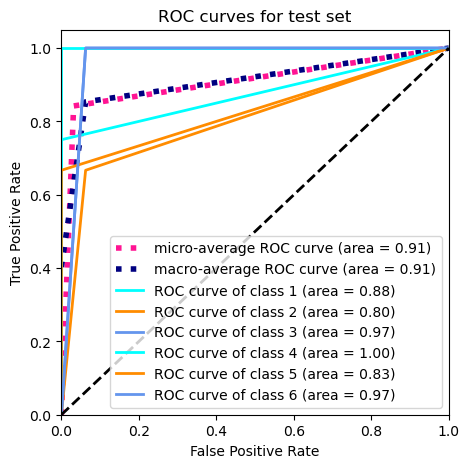

In [53]:
# ROC curves for test set 
y_test = pd.DataFrame(y_test)["class"].map({"bending":"1","cycling":"2","lying":"3","sitting":"4",
                                               "standing":"5","walking":"6"})
y_test_pred = pd.DataFrame(y_test_pred)[0].map({"bending":"1","cycling":"2","lying":"3","sitting":"4",
                                                  "standing":"5","walking":"6"})

y_test = label_binarize(y_test, classes=["1","2","3","4","5","6"])
y_test_pred = label_binarize(y_test_pred, classes=["1","2","3","4","5","6"])

fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_test.shape[1]):
    fpr[i],tpr[i],_ = roc_curve(y_test[:,i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"],tpr["micro"], _ = roc_curve(y_test.ravel(), y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_test.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_test.shape[1]):
    mean_tpr += interp(all_fpr,fpr[i],tpr[i])

# Finally average it and compute AUC
mean_tpr /= y_test.shape[1]
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label="micro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc["micro"]),
         color="deeppink", linestyle=":", linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label="macro-average ROC curve (area = {0:0.2f})"
               "".format(roc_auc["macro"]),
         color="navy", linestyle=":", linewidth=4)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(y_test.shape[1]), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label="ROC curve of class {0} (area = {1:0.2f})"
             "".format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves for test set")
plt.legend(loc="lower right")
plt.show()

### 4.c.ii
Repeat 4(c)i using a **Naive Bayes’ classifier**. Use both **Gaussian** and **Multinomial priors** and compare the results.

In [54]:
# use Naive Bayes’ classifier-Gaussian priors
clfG = GaussianNB()
l_train_error = {}
for l in range(1,21):
    df = "train_f_"+str(l)
    X_train = locals()[df].loc[:,:locals()[df].columns[-4]]
    y_train = locals()[df]["class"]
    clfG.fit(X_train,y_train)
    y_train_pred = clfG.predict(X_train)
    train_error = 1-accuracy_score(y_train,y_train_pred)
    l_train_error[l] = train_error
print(l_train_error)

{1: 0.02898550724637683, 2: 0.01449275362318836, 3: 0.04347826086956519, 4: 0.04347826086956519, 5: 0.05797101449275366, 6: 0.04347826086956519, 7: 0.02898550724637683, 8: 0.05797101449275366, 9: 0.01449275362318836, 10: 0.0, 11: 0.02898550724637683, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.02898550724637683, 17: 0.0, 18: 0.02898550724637683, 19: 0.0, 20: 0.01449275362318836}


In [55]:
# find best l
optimal_l = min(l_train_error, key=l_train_error.get)
print("optimal l is:",optimal_l,"and its train error is:",l_train_error[optimal_l])

optimal l is: 10 and its train error is: 0.0


In [56]:
l = optimal_l
for df in testsets:
    tmp = break_time_series_l(locals()[df],l)
    if df == "bending1_1":
        locals()["df_test_"+str(l)] = tmp
    else:
        locals()["df_test_"+str(l)] = pd.concat([locals()["df_test_"+str(l)],tmp])
# df_test_2 = df_test_2.reset_index().drop(["index","time_1","time_2"],axis=1)
locals()["df_test_"+str(l)] = locals()["df_test_"+str(l)].reset_index().drop(["index"],axis=1)

i = optimal_l
tmp_df_test = locals()["df_test_"+str(i)]
for dataset in testsets:
    df = tmp_df_test[tmp_df_test["dataset"]==dataset]
    tmp = row_of_3_fearure_each(df)
    if dataset == "bending1_1":
        locals()["test_f_"+str(i)] = tmp
    else:
        locals()["test_f_"+str(i)] = pd.concat([locals()["test_f_"+str(i)],tmp])

locals()["test_f_"+str(i)] = locals()["test_f_"+str(i)].reset_index().drop(["index"],axis=1)
locals()["test_f_"+str(i)].loc[locals()["test_f_"+str(i)]["class"]=="bending","b_class"] = "1"
locals()["test_f_"+str(i)].loc[locals()["test_f_"+str(i)]["class"]!="bending","b_class"] = "0"

# refit and test 
X_train = train_f_10.loc[:,:train_f_10.columns[-4]]
y_train = train_f_10["class"]
clfG.fit(X_train,y_train)

X_test = locals()["test_f_"+str(i)].loc[:,:locals()["test_f_"+str(i)].columns[-4]]
y_test = locals()["test_f_"+str(i)]["class"]
y_test_pred = clfG.predict(X_test)
1-accuracy_score(y_test,y_test_pred)

0.21052631578947367

In [57]:
# use Naive Bayes’ classifier-Multinomial priors
clfM = MultinomialNB()
l_train_error = {}
for l in range(1,21):
    df = "train_f_"+str(l)
    X_train = locals()[df].loc[:,:locals()[df].columns[-4]]
    y_train = locals()[df]["class"]
    clfM.fit(X_train,y_train)
    y_train_pred = clfM.predict(X_train)
    train_error = 1-accuracy_score(y_train,y_train_pred)
    l_train_error[l] = train_error
print(l_train_error)

{1: 0.18840579710144922, 2: 0.14492753623188404, 3: 0.1159420289855072, 4: 0.13043478260869568, 5: 0.1159420289855072, 6: 0.1159420289855072, 7: 0.08695652173913049, 8: 0.08695652173913049, 9: 0.08695652173913049, 10: 0.08695652173913049, 11: 0.08695652173913049, 12: 0.05797101449275366, 13: 0.07246376811594202, 14: 0.04347826086956519, 15: 0.04347826086956519, 16: 0.04347826086956519, 17: 0.04347826086956519, 18: 0.04347826086956519, 19: 0.04347826086956519, 20: 0.04347826086956519}


In [58]:
# find best l
optimal_l = min(l_train_error, key=l_train_error.get)
print("optimal l is:",optimal_l,"and its train error is:",l_train_error[optimal_l])

optimal l is: 14 and its train error is: 0.04347826086956519


In [59]:
l = optimal_l
for df in testsets:
    tmp = break_time_series_l(locals()[df],l)
    if df == "bending1_1":
        locals()["df_test_"+str(l)] = tmp
    else:
        locals()["df_test_"+str(l)] = pd.concat([locals()["df_test_"+str(l)],tmp])
# df_test_2 = df_test_2.reset_index().drop(["index","time_1","time_2"],axis=1)
locals()["df_test_"+str(l)] = locals()["df_test_"+str(l)].reset_index().drop(["index"],axis=1)

i = optimal_l
tmp_df_test = locals()["df_test_"+str(i)]
for dataset in testsets:
    df = tmp_df_test[tmp_df_test["dataset"]==dataset]
    tmp = row_of_3_fearure_each(df)
    if dataset == "bending1_1":
        locals()["test_f_"+str(i)] = tmp
    else:
        locals()["test_f_"+str(i)] = pd.concat([locals()["test_f_"+str(i)],tmp])

locals()["test_f_"+str(i)] = locals()["test_f_"+str(i)].reset_index().drop(["index"],axis=1)
locals()["test_f_"+str(i)].loc[locals()["test_f_"+str(i)]["class"]=="bending","b_class"] = "1"
locals()["test_f_"+str(i)].loc[locals()["test_f_"+str(i)]["class"]!="bending","b_class"] = "0"

# refit and test 
X_train = train_f_14.loc[:,:train_f_14.columns[-4]]
y_train = train_f_14["class"]
clfM.fit(X_train,y_train)

X_test = locals()["test_f_"+str(i)].loc[:,:locals()["test_f_"+str(i)].columns[-4]]
y_test = locals()["test_f_"+str(i)]["class"]
y_test_pred = clfM.predict(X_test)
1-accuracy_score(y_test,y_test_pred)

0.1578947368421053

**compare results**

    For Naive Bayes’ classifier using Gaussian priors the optimal l is 10 and its corresponding train error is 0, while the optimal l is 14 and its corresponding train error is 0.04 when using Multinomial priors.

    The one using  Multinomial priors is a little higher than the one using Gaussian priors, however both of them are likely to be too low to be overfitting.

### 4.c.iii
Which method is better for multi-class classification in this problem?

    We have used L1-penalized multinomial regression model in 4.c.i, and Naive Bayes’ classifier using Gaussian and Multinomia priors in 4.c.ii. Their corresponding test error is 0.16, 0.21 and 0.16

    I think L1-penalized multinomial regression model is better for multi-class classification since it has lowest test error and split value.

### 5. ISLR, 4.8.3
This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a **class-specific mean vector** and a **class specific covariance matrix**. We consider the simple case where **p = 1**; i.e. there is only one feature.

Suppose that we have **K** classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, **X ∼ N(${μ}_k$,${σ}_k^2$)**. Recall that the density function for the one-dimensional normal distribution is given in (4.16). **Prove** that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.

**Hint**: For this problem, you should follow the arguments laid out in Section 4.4.1, but without making the assumption that ${σ}_1^2$= . . . = ${σ}_k^2$.

### Answer
proof:

When using QDA model, we have to find the k* which makes ${p}_k(x)$  largest, and means that:

k* = argmax(${p}_k(x)$)

= argmax(${\frac{1}{\sqrt{2\pi}{σ}_k}}$${e}^\frac{{−(x−{μ}_k)}^2}{2{{σ}_k}^2}$)

   = argmax(log${\pi}_k$-log${\sqrt{2\pi}{σ}_k}$-$\frac{{−(x−{μ}_k)}^2}{2{{σ}_k}^2}$)
   
= argmax(log${\pi}_k$-log${{σ}_k}$-$\frac{1}{2}$($\frac{{x}^2}{{{σ}_k}^2}-\frac{2x{μ}_k}{{{σ}_k}^2}+\frac{{{μ}_k}^2}{{{σ}_k}^2}$)) 

then we have: ${\delta}_k(x)$ = log${\pi}_k$-log${{σ}_k}$-$\frac{1}{2}$($\frac{{x}^2}{{{σ}_k}^2}-\frac{2x{μ}_k}{{{σ}_k}^2}+\frac{{{μ}_k}^2}{{{σ}_k}^2}$)

and then the Bayes classifier is not linear since ${\delta}_k(x)$ is a quadratic function of x

### 6. ISLR 4.8.7
Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was **${X}^-$ = 10**, while the mean for those that didn’t was **${X}^-$ = 0**. In addition, the variance of X for these two sets of companies was ${σˆ}^2$ = 36. Finally, **80%** of companies issued dividends. Assuming that X follows a **normal distribution**, predict the probability that a company will issue a dividend this year given that its percentage profit was **X = 4** last year.

**Hint**: Recall that the density function for a normal random variable is f(x)=${\frac{1}{\sqrt{2\pi{σ}^2}}}$${e}^\frac{{−(x−μ)}^2}{2{σ}^2}$.
You will need to use Bayes’ theorem

### Answer

from the question, we want to get ${p}_1(4)$ and can know that:

K = 2, ${\pi}_1$ = 80% = 0.8, ${\pi}_2$ = 20% = 0.2, 
x = 4, ${\mu}_1$ = 10，${\mu}_2$ = 0

and for both sets ${σˆ}^2$ = 36

so

${p}_1(4)$ = $\frac{0.8*{e}^\frac{−{(4−10)}^2}{2*36}}{0.8*{e}^\frac{−{(4−10)}^2}{2*36}+0.2*{e}^\frac{−{(4−0)}^2}{2*36}}$ = 0.752